## 一、背景

图像的智能处理一直是人工智能领域广受关注的一类技术，代表性的如人脸识别与 CT 肿瘤识别，在人工智能落地的进程中发挥着重要作用。其中车牌号识别作为一个早期应用场景，已经融入日常生活中，为我们提供了诸多便利，在各地的停车场和出入口都能看到它的身影。车牌号识别往往分为字符划分和字符识别两个子任务，本案例我们将关注字符识别的任务，尝试用 K-NN 的方法对分割好的字符图像进行自动识别和转化。

## 二、任务

* 完成数据的读入和表示，将图片表示成向量并和 label 对应上；
* 分析当 K 取不同值时测试准确率的变化；
* 分析不同距离度量方式对模型效果的影响；
* 对比平权和加权 K-NN 的效果；
* 分析训练集大小对测试结果的影响。

## 三、评价指标
构建 K-NN 模型对测试集中的图片进行预测并计算准确率。

## 四、数据概览
按字符划分的车牌图片作为数据集，已放在在Data文件夹下，已经分成了训练集(train文件夹)和测试集（test文件夹）。训练集和测试集都分包括数字10个（0-9）、大写字母24个（A-Z，不包含 O 和 I）、省份简称31个，共计 65 个类（编号从 0 到 64）的20*20图片。文件夹名称即为标签。



In [1]:
import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

下面演示一下如何借助 PIL 库将图片转化为向量：

In [2]:
img = Image.open('data/train/0/4-3.jpg')  # 打开图片
img  # 显示图片
pixels = np.array(img)  # 转化为 numpy 矩阵
pixels.shape

(20, 20)

按train和test两个文件夹对应读取训练集和测试集

In [3]:
def load_data(path):
    img_nparray = []
    label = []

    file_0 = os.listdir(path)                                           # 取文件夹下的的文件或文件夹列表
    if file_0 and file_0[0] == '.DS_Store' :
        file_0.pop(0)                                                   # 移除文件.DS_Store

    for f in range(len(file_0)):
        file_temp = file_0[f]
        file_temp = os.path.join(path,file_temp)        
        file_1 = os.listdir(file_temp)
        if file_1 and file_1[0] == '.DS_Store' :
            file_1.pop(0)                                               # 移除文件.DS_Store
        for file in file_1:
            img = Image.open(os.path.join(file_temp,file))
            pixels = np.array(img)                                      # 转化为 numpy 矩阵
            img_nparray.append(pixels.flatten())                        # 降维
            label.append(file_0[f])                                     # 取标签

    return np.array(img_nparray),np.array(label)


train_x, train_y = load_data('./data/train')                            # 训练集 
test_x, test_y = load_data('./data/test')                               # 测试集

assert(len(train_x) == len(train_y) and len(test_x) == len(test_y))    # 断言 训练集和测试集的特征、标签长度必须分别一致

数据集可视化:随机取10个样本，通过指定下标和维数，画灰度图

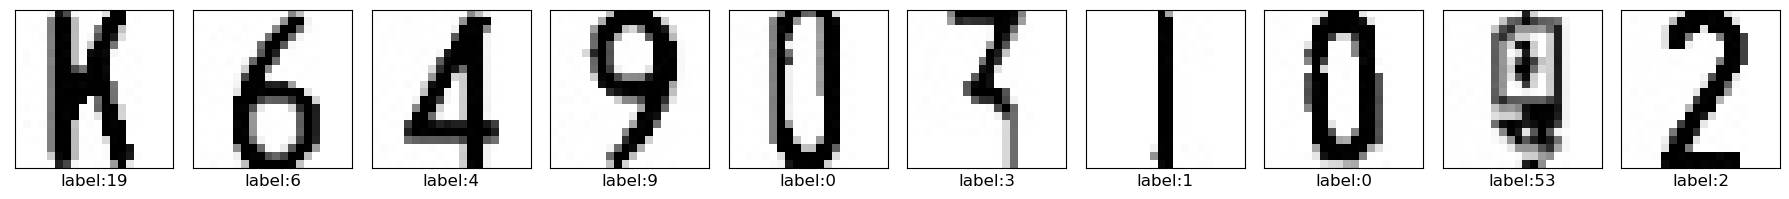

In [4]:
def draw(imgs, labels, dim = 20):
    rows, cols = math.ceil(len(imgs)/10), 10
    figs, axs = plt.subplots(
        nrows=rows,
        ncols=cols,
        sharex=True,
        sharey=True, figsize=(18, 2*rows))

    axs = axs.flatten()
    for img, label, ax in zip(imgs, labels, axs):
        img = img.reshape(dim, dim)
        ax.imshow(img, cmap='Greys', interpolation='nearest')
        ax.set_xlabel("label:" + label, size=12)

    axs[0].set_xticks([])                                                           # 去除X轴坐标刻度
    axs[0].set_yticks([])                                                           # 去除Y轴坐标刻度
    plt.tight_layout()
    plt.show()

train_random_10 = np.random.randint(0, len(train_x), 10)                            # 随机取10个样本观察
train_x_10 = train_x[train_random_10]
train_y_10 = train_y[train_random_10]
draw(train_x_10, train_y_10)

## 五、模型构建

直接使用sklearn库的KNeighborsClassifier实现K近邻算法。

In [5]:
def building(train_x, train_y, test_x, test_y,neighbors=1, weights='distance', p=1,remark='' ):
    clf = KNeighborsClassifier(n_neighbors=neighbors, weights= weights, p=p)
    clf.fit(train_x, train_y)
    t1 = time.time()
    res = clf.score(test_x, test_y)
    t2 = time.time()
    if not remark or remark == '' :
        print("Test time ", t2-t1, "  Accurancy ", res)
    else :
        print(remark + "  Test time ", t2-t1, "  Accurancy ", res)

### 5.1 原始数据模型

先考虑直接使用原始的数据进行建模。

In [6]:

building(train_x, train_y, test_x, test_y, remark='原始数据模型：')

原始数据模型：  Test time  27.209497213363647   Accurancy  0.7144694533762058


### 5.2 清晰度处理模型

在上面的数据概览中我们发现，有部分图片不够清晰，也有部分图片有噪点。可以先考虑对图片进行清晰化和降噪。

In [88]:

def img_clear(train_x, test_x, max_thed = 100, min_thed = 40):
    train_x_clear,test_x_clear = train_x.copy(),test_x.copy()                   # 复制训练集和测试集
    train_x_clear[train_x_clear >= max_thed] = 255                              # 训练集清晰化
    test_x_clear[test_x_clear >= max_thed] = 255                                # 测试集清晰化
    train_x_clear[train_x_clear < min_thed] = 0                                 # 训练集降噪
    test_x_clear[test_x_clear < min_thed] = 0                                   # 测试集降噪
    return train_x_clear, test_x_clear

train_x_clear, test_x_clear = img_clear(train_x, test_x)
building(train_x_clear, train_y, test_x_clear, test_y, remark='清晰度处理模型：')

清晰度处理模型：  Test time  48.02613186836243   Accurancy  0.767416934619507


### 5.3 网格划分法模型

“原始数据模型”和“清晰度处理模型”中，执行的时间复杂度过高。考虑降维。 使用网格划分法对降维后的数据进行knn，来确定最合适的参数。网格划分法将（20,20）大小的图片等分划分为n块，每个像素点的取值实验PIL库中提供的两种方式：临近方式（NEAREST）和线性插值方式（BILINEAR）。

In [8]:

def img_grid(train_x, test_x, resize = 10, pil=Image.BILINEAR):
    # 网格划分法训练集
    train_x_grid = np.zeros((len(train_x), resize**2))
    for x in range(0, len(train_x)):
        pic = Image.fromarray(train_x[x].reshape(20, 20).astype('uint8'))
        pic = pic.resize((resize, resize), pil)
        xx = np.array(pic)
        train_x_grid[x] = xx.flatten()

    # 网格划分法测试集验证
    test_x_grid = np.zeros((len(test_x), resize**2))
    for x in range(0, len(test_x)):
        pic = Image.fromarray(test_x[x].reshape(20, 20).astype('uint8'))
        pic = pic.resize((resize, resize), pil)
        xx = np.array(pic)
        test_x_grid[x] = xx.flatten()
    return train_x_grid, test_x_grid
    
train_x_grid, test_x_grid = img_grid(train_x, test_x)
building(train_x_grid, train_y, test_x_grid, test_y, remark='网格化分法模型：')

网格化分法模型：  Test time  12.016231298446655   Accurancy  0.7262593783494105


### 5.4 PCA提取主成分模型

PCA主成分分析法从原始的空间中顺序地找一组相互正交的坐标轴，保留前N个方差最大的方向（也是最有代表性的特征）做为提取出的主成分的数学分析方法。为网格划分法保持一致，此处提取前25个特征，以保证维度相同。

In [9]:

def img_pca(train_x, test_x):
    # 使用PCA提取主成分划分法测试集验证
    pca = PCA(n_components=100)
    pca.fit(train_x)
    train_x_pca = pca.transform(train_x)
    test_x_pca = pca.transform(test_x)
    return train_x_pca, test_x_pca

train_x_pca, test_x_pca = img_pca(train_x, test_x)
building(train_x_pca, train_y, test_x_pca, test_y, remark='PCA提取主成分模型：')

PCA提取主成分模型：  Test time  12.593926191329956   Accurancy  0.7033226152197213


### 5.5 图像对比

对比 原图/清晰度处理/网格划分法/PCA主成分提取后的图片，进行可视化对比。

原始图像预览：


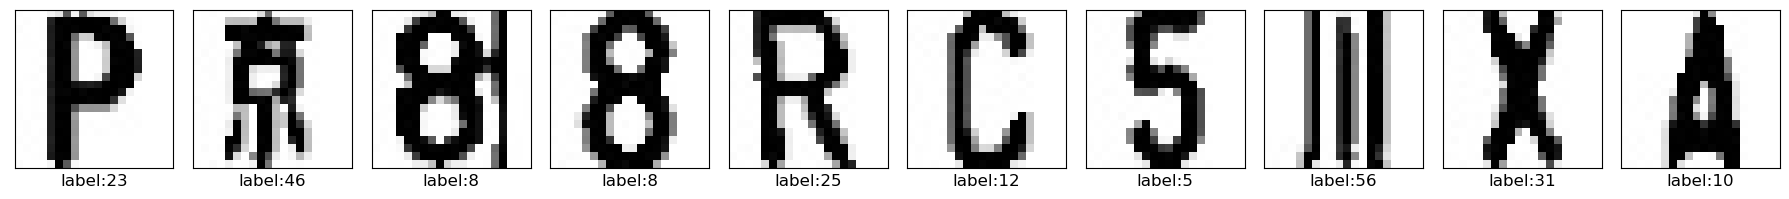

清晰度处理法图像预览：


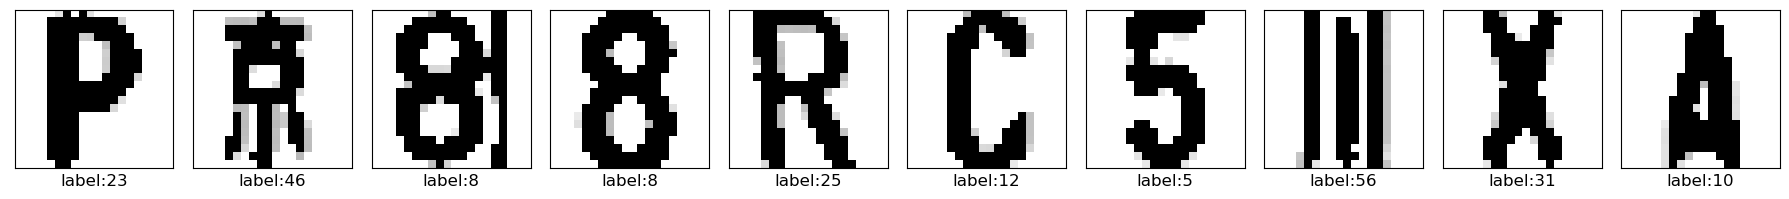

网格划分法图像预览：


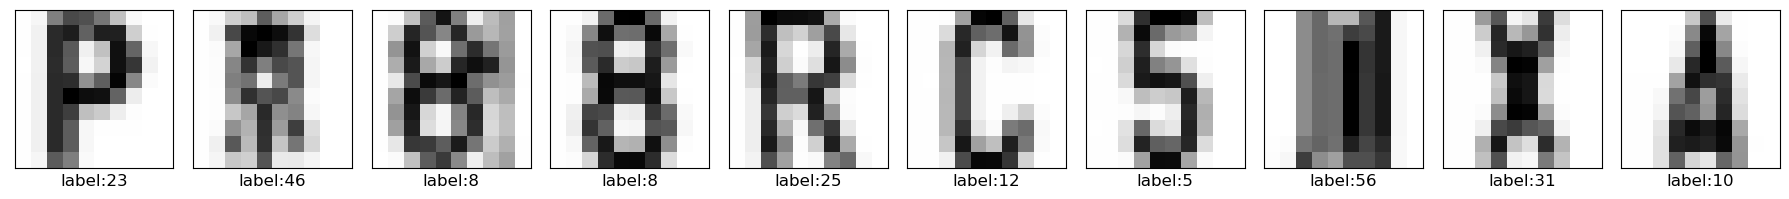

PCA提取主成法图像预览：


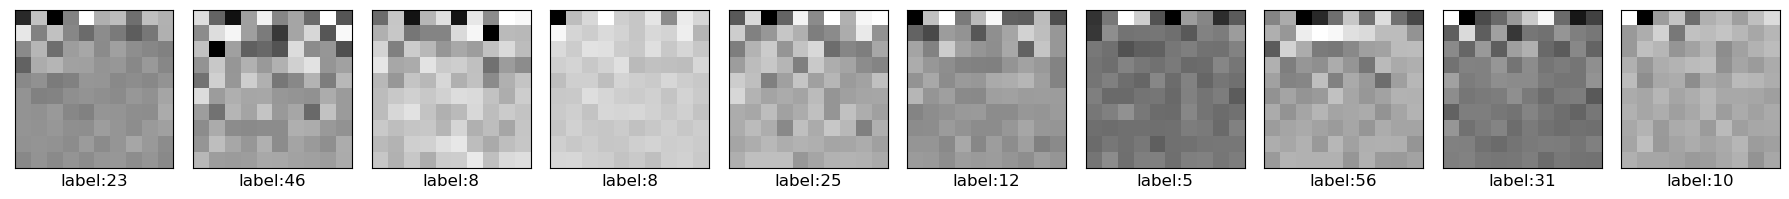

In [10]:

print('原始图像预览：')
draw(train_x_10, train_y_10, dim= 20)

print('清晰度处理法图像预览：')
train_x_clear_10 = train_x_clear[train_random_10]
draw(train_x_clear_10, train_y_10, dim= 20)

print('网格划分法图像预览：')
train_x_grid_10 = train_x_grid[train_random_10]
draw(train_x_grid_10, train_y_10, dim= 10)

print('PCA提取主成法图像预览：')
train_x_pca_10 = train_x_pca[train_random_10]
draw(train_x_pca_10, train_y_10, dim= 10)

## 六、模型调优

KNN分类中共有三类超参数需要选择：K值、距离和分是否带权。K值选奇数避免平局；距离选L1曼哈顿距离（L1）和欧式距离（L2）；带权用'uniform'表示所有点的权重相等、用'distance'表示权重是距离的倒数。

### 6.1 原始数据模型调优

原始数据模型没，因为没对数据进行更多处理，就调K值、距离和分是否带权三个参数。

In [71]:
exec_reult = pd.DataFrame(columns=['score','neighbor','weight','p'])                            # 记录模型参数和评价

for neighbor in [1, 3, 5, 7]:                                                                   # K值
    for weight in ['uniform', 'distance']:                                                      # 是否带权
        for p in [1, 2]:                                                                        # 闵可夫斯基空间
            clf = KNeighborsClassifier(n_neighbors=neighbor, weights= weight, p=p)            
            cur_score = cross_val_score(clf, train_x, train_y, cv=3, scoring='accuracy')
            avg_score = cur_score.mean()
            exec_reult.loc[exec_reult.shape[0]]=[avg_score, neighbor, weight, p ]
                
# print(exec_reult)
print('原始数据模型调优:')
best = exec_reult['score'].idxmax()
print(exec_reult.loc[best])

原始数据模型调优:
score       0.967782
neighbor           1
weight       uniform
p                  2
Name: 1, dtype: object


### 6.2 清晰度处理模型调优

清晰度处理模型中，数据处理部分有清晰化阀值和降噪的阀值，对结果的影响可能比较大。可以取不同的值与K值、距离和分是否带权三个超参一直来反复调优。

In [27]:
exec_reult_clear = pd.DataFrame(columns=['score','neighbor','weight','p', 'max_thed', 'min_thed'])  # 记录模型参数和评价

for max_thed in [50, 100, 150, 200]:                                                                # 清晰化阀值
    for min_thed in [10, 20, 40, 60]:                                                               # 降噪阀值
        train_x_clear, test_x_clear = img_clear(train_x, test_x, max_thed, min_thed)                      
        for neighbor in [1, 3, 5, 7]:                                                               # K值
            for weight in ['uniform', 'distance']:                                                  # 是否带权
                for p in [1, 2]:                                                                    # 闵可夫斯基空间                
                    clf = KNeighborsClassifier(n_neighbors=neighbor, weights= weight, p=p)            
                    cur_score = cross_val_score(clf, train_x_clear, train_y, cv=3, scoring='accuracy')
                    avg_score = cur_score.mean()
                    exec_reult_clear.loc[exec_reult_clear.shape[0]]=[avg_score, neighbor, weight, p, max_thed, min_thed ]
                
# print(exec_reult_clear)
print('清晰度模型调优:')
best = exec_reult_clear['score'].idxmax()
print(exec_reult_clear.loc[best])


清晰度模型调优:
score       0.953554
neighbor           1
weight       uniform
p                  2
max_thed          50
min_thed          20
Name: 1, dtype: object


### 6.3 网格划分法模型调优

网格划分法将（20,20）大小的图片划分为小块的块数和每个像素点的取值实验的不同方式，都会对结果有影响。可以取不同的值与K值、距离和分是否带权三个超参一直来反复调优。

In [28]:
exec_reult_grid = pd.DataFrame(columns=['score','neighbor','weight','p', 'grid_size', 'pil'])       # 记录模型参数和评价

for pil_name,pil in zip(['NEAREST', 'BILINEAR'],[Image.NEAREST, Image.BILINEAR]):                   # 临近方式（NEAREST）和线性插值方式（BILINEAR）
    for grid_size in [5, 10]:                                                                       # 网格大小
        train_x_grid, test_x_grid = img_grid(train_x, test_x, grid_size, pil)
        for neighbor in [1, 3, 5, 7]:                                                               # K值
            for weight in ['uniform', 'distance']:                                                  # 是否带权
                for p in [1, 2]:                                                                    # 闵可夫斯基空间                
                    clf = KNeighborsClassifier(n_neighbors=neighbor, weights= weight, p=p)            
                    cur_score = cross_val_score(clf, train_x_grid, train_y, cv=3, scoring='accuracy')
                    avg_score = cur_score.mean()
                    exec_reult_grid.loc[exec_reult_grid.shape[0]]=[avg_score, neighbor, weight, p, grid_size ,pil_name]
                
#print(exec_reult_grid)
print('网格划分法模型调优:')
best = exec_reult_grid['score'].idxmax()
print(exec_reult_grid.loc[best])


网格划分法模型调优:
score        0.963081
neighbor            1
weight        uniform
p                   2
grid_size          10
pil          BILINEAR
Name: 49, dtype: object


### 6.4 PCA提取主成分模型调优

PCA提取主成分模型的调优与原始数据方法的调优，方法基本一致。

In [29]:
exec_reult_pca = pd.DataFrame(columns=['score','neighbor','weight','p'])                        # 记录模型参数和评价

for neighbor in [1, 3, 5, 7]:                                                                   # K值
    for weight in ['distance','uniform']:                                                       # 是否带权
        for p in [1, 2]:                                                                        # 闵可夫斯基空间
            clf = KNeighborsClassifier(n_neighbors=neighbor, weights= weight, p=p)            
            cur_score = cross_val_score(clf, train_x_pca, train_y, cv=3, scoring='accuracy')
            avg_score = cur_score.mean()
            exec_reult_pca.loc[exec_reult_pca.shape[0]]=[avg_score, neighbor, weight, p ]
                
# print(exec_reult_pca)
print('PCA提取主成分模型调优:')
best = exec_reult_pca['score'].idxmax()
print(exec_reult_pca.loc[best])

PCA提取主成分模型调优:
score       0.968033
neighbor           1
weight       uniform
p                  2
Name: 1, dtype: object


## 七、模型对比

### 7.1	“K，权重，距离计算方法”对准确率的影响

    neighbor    weight  p     score
0          1  distance  1  0.911950
1          1  distance  2  0.915758
2          1   uniform  1  0.911950
3          1   uniform  2  0.915758
4          3  distance  1  0.911386
5          3  distance  2  0.915523
6          3   uniform  1  0.899524
7          3   uniform  2  0.905181
8          5  distance  1  0.910305
9          5  distance  2  0.914943
10         5   uniform  1  0.895622
11         5   uniform  2  0.902125
12         7  distance  1  0.908753
13         7  distance  2  0.914034
14         7   uniform  1  0.892221
15         7   uniform  2  0.899022


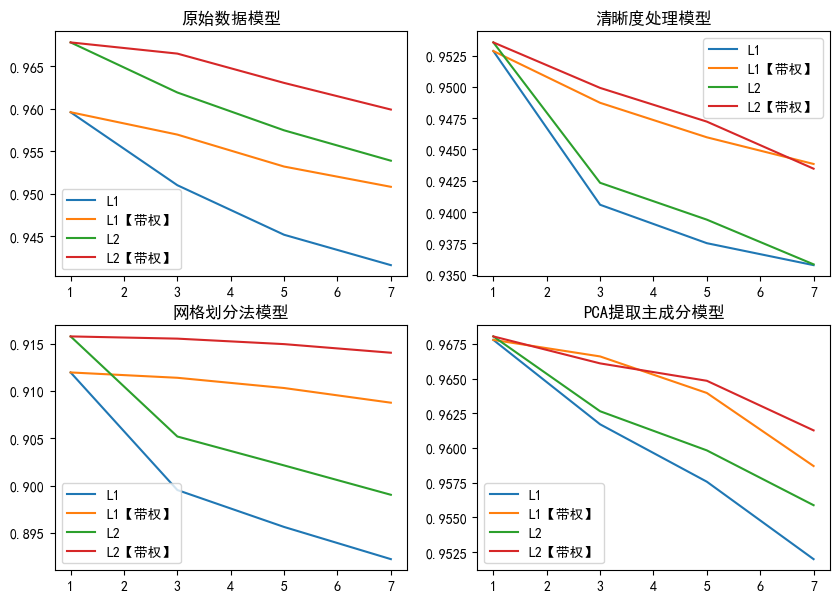

In [72]:
ks = [1, 3, 5, 7]

plt.figure(figsize=(10, 7), dpi=100)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
ax1 = plt.subplot(221)
ax1.plot(exec_reult.query("weight=='uniform' & p==1")['neighbor'].values.tolist(), exec_reult.query("weight=='uniform' & p==1")['score'].values.tolist(), label='L1')
ax1.plot(exec_reult.query("weight=='distance' & p==1")['neighbor'].values.tolist(), exec_reult.query("weight=='distance' & p==1")['score'].values.tolist(), label='L1【带权】')
ax1.plot(exec_reult.query("weight=='uniform' & p==2")['neighbor'].values.tolist(), exec_reult.query("weight=='uniform' & p==2")['score'].values.tolist(), label='L2')
ax1.plot(exec_reult.query("weight=='distance' & p==2")['neighbor'].values.tolist(), exec_reult.query("weight=='distance' & p==2")['score'].values.tolist(), label='L2【带权】')
ax1.set_title('原始数据模型')
ax1.legend()

ax2 = plt.subplot(222)
ax2.plot(exec_reult_clear.query("weight=='uniform' & p==1")['neighbor'].values.tolist(), exec_reult_clear.query("weight=='uniform' & p==1")['score'].values.tolist(), label='L1')
ax2.plot(exec_reult_clear.query("weight=='distance' & p==1")['neighbor'].values.tolist(), exec_reult_clear.query("weight=='distance' & p==1")['score'].values.tolist(), label='L1【带权】')
ax2.plot(exec_reult_clear.query("weight=='uniform' & p==2")['neighbor'].values.tolist(), exec_reult_clear.query("weight=='uniform' & p==2")['score'].values.tolist(), label='L2')
ax2.plot(exec_reult_clear.query("weight=='distance' & p==2")['neighbor'].values.tolist(), exec_reult_clear.query("weight=='distance' & p==2")['score'].values.tolist(), label='L2【带权】')
ax2.set_title('清晰度处理模型')
ax2.legend()

ax3 = plt.subplot(223)
exec_reult_grid_group = exec_reult_grid.copy()[['neighbor','weight','p','score']]
exec_reult_grid_group= exec_reult_grid_group.groupby(['neighbor','weight','p'],as_index=False).mean()
exec_reult_grid_group = pd.DataFrame(exec_reult_grid_group)
print(exec_reult_grid_group)
ax3.plot(exec_reult_grid_group.query("weight=='uniform' & p==1")['neighbor'].values.tolist(), exec_reult_grid_group.query("weight=='uniform' & p==1")['score'].values.tolist(), label='L1')
ax3.plot(exec_reult_grid_group.query("weight=='distance' & p==1")['neighbor'].values.tolist(), exec_reult_grid_group.query("weight=='distance' & p==1")['score'].values.tolist(), label='L1【带权】')
ax3.plot(exec_reult_grid_group.query("weight=='uniform' & p==2")['neighbor'].values.tolist(), exec_reult_grid_group.query("weight=='uniform' & p==2")['score'].values.tolist(), label='L2')
ax3.plot(exec_reult_grid_group.query("weight=='distance' & p==2")['neighbor'].values.tolist(), exec_reult_grid_group.query("weight=='distance' & p==2")['score'].values.tolist(), label='L2【带权】')
ax3.set_title('网格划分法模型')
ax3.legend()

ax4 = plt.subplot(224)
ax4.plot(exec_reult_pca.query("weight=='uniform' & p==1")['neighbor'].values.tolist(), exec_reult_pca.query("weight=='uniform' & p==1")['score'].values.tolist(), label='L1')
ax4.plot(exec_reult_pca.query("weight=='distance' & p==1")['neighbor'].values.tolist(), exec_reult_pca.query("weight=='distance' & p==1")['score'].values.tolist(), label='L1【带权】')
ax4.plot(exec_reult_pca.query("weight=='uniform' & p==2")['neighbor'].values.tolist(), exec_reult_pca.query("weight=='uniform' & p==2")['score'].values.tolist(), label='L2')
ax4.plot(exec_reult_pca.query("weight=='distance' & p==2")['neighbor'].values.tolist(), exec_reult_pca.query("weight=='distance' & p==2")['score'].values.tolist(), label='L2【带权】')
ax4.set_title('PCA提取主成分模型')
ax4.legend()

可以发现，四种模型下，都有一致的特点：
* k取1时，有着最佳性能。并且K的取值与性能成反比关系。
* 距离计算使用L2基本上都比L1好。
* 得分计算使用带权计算比使用不带权计算，有着更好的性能，而且好得多。

### 7.2	最佳模型

结合上面“模型调优”和“K、权重、距离计算方法”对准确率的影响分析，“K、权重距离计算方法”的值分别取1、'distance'、2, 分别代入对应模型测试。

In [90]:

building(train_x, train_y, test_x, test_y, remark='原始数据模型：')


train_x_clear, test_x_clear = img_clear(train_x, test_x, 50, 20)
building(train_x_clear, train_y, test_x_clear, test_y, 1, 'distance', 2, remark='清晰度处理模型：')

train_x_grid, test_x_grid = img_grid(train_x, test_x, 15, Image.BILINEAR)
building(train_x_grid, train_y, test_x_grid, test_y, 1, 'distance', 2, remark='网格化分法模型：')

train_x_pca, test_x_pca = img_pca(train_x, test_x)
building(train_x_pca, train_y, test_x_pca, test_y, 1, 'distance', 2, remark='PCA提取主成分模型：')

原始数据模型：  Test time  44.878920793533325   Accurancy  0.7144694533762058
清晰度处理模型：  Test time  2.789379119873047   Accurancy  0.7834941050375134
网格化分法模型：  Test time  2.6064846515655518   Accurancy  0.7187566988210075
PCA提取主成分模型：  Test time  1.9189023971557617   Accurancy  0.712540192926045


对比四个模型的最佳结果， **清晰度处理模型效果最佳：Accurancy取值为0.7835**。

### 7.3	训练集大小对结果的影响

训练集大小对最佳模型“清晰度处理模型”的影响如下：

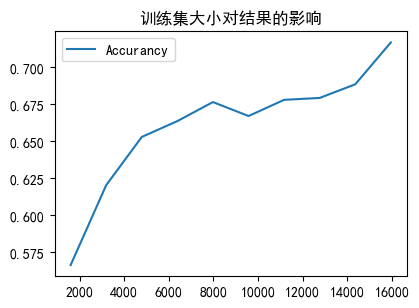

In [120]:
train_x_counts,accurancys = [],[]

train_x_clear_s, test_x_clear_s = img_clear(train_x_scale, test_x_scale, 50, 20)
clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=2)
clf.fit(train_x, train_y)
accurancys.append(clf.score(test_x, test_y))
train_x_counts.append(len(train_x))

for scale in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    train_x_scale, test_x_scale, train_y_scale, test_y_scale = train_test_split(train_x, train_y, test_size=scale, random_state=100)
    train_x_clear_s, test_x_clear_s = img_clear(train_x_scale, test_x_scale, 50, 20)
    clf = KNeighborsClassifier(n_neighbors=1, weights='distance', p=2)
    clf.fit(train_x_clear_s, train_y_scale)
    score = clf.score(test_x, test_y)
    accurancys.append(score)
    train_x_counts.append(len(train_x_clear_s))
    # print('训练集样本' + len(train_x_clear_s))+ '条  accurancy' + score)

plt.figure(figsize=(10, 7), dpi=100)
plt.rcParams['font.sans-serif'] = ['SimHei']                        # 用来正常显示中文标签
ax1 = plt.subplot(221)
ax1.plot(train_x_counts, accurancys, label='Accurancy')
ax1.set_title('训练集大小对结果的影响')
ax1.legend()